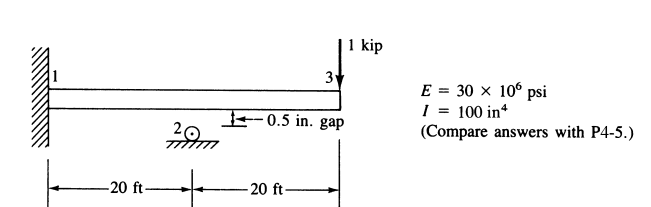

In [132]:
import numpy as np
import pandas as pd

In [133]:
# creating nodes
columns = ['coordinate','displacement','slope','load','moment']
data = [[0,0,0,np.nan,np.nan],
        [240,-0.5,np.nan,np.nan,0],
        [480,np.nan,np.nan,-1000,0]]
nodes = pd.DataFrame(data,columns=columns)
nodes

,coordinate,displacement,slope,load,moment
0,0,0.0,0.0,NaN,NaN
1,240,-0.5,NaN,NaN,0.0
2,480,NaN,NaN,-1000.0,0.0


In [134]:
# creating elements
columns = ['start','end','length','material','MoI']
data = [[0,1,240,30e6,100],
        [1,2,240,30e6,100]]
elements = pd.DataFrame(data,columns=columns)
elements

,start,end,length,material,MoI
0,0,1,240,30000000.0,100
1,1,2,240,30000000.0,100


In [135]:
# creating local stiffness matrix for each element
def compute_localK(element):
    L = element['length']
    c = element['material']*element['MoI']/(L**3)
    k = np.array([[12, 6*L, -12, 6*L],
                [6*L, 4*L*L, -6*L, 2*L*L],
                [-12, -6*L, 12, -6*L],
                [6*L, 2*L*L, -6*L, 4*L*L]])*c
    return k
elements['k'] = elements.apply(compute_localK,axis=1)
elements

,start,end,length,material,MoI,k
0,0,1,240,30000000.0,100,"[[2604.1666666666665, 312500.0, -2604.16666666..."
1,1,2,240,30000000.0,100,"[[2604.1666666666665, 312500.0, -2604.16666666..."


In [136]:
def compute_globalK(element):
    N = len(nodes)
    indices = np.arange(N*2)
    indices = indices.reshape(-1,2)

    K = np.zeros([N*2,N*2])

    start = element['start']
    end = element['end']
    indices = np.hstack([indices[start],indices[end]])
    K[np.ix_(indices,indices)] = element['k']

    return K
K = elements.apply(compute_globalK,axis=1).sum()
K  

array([[ 2.60416667e+03,  3.12500000e+05, -2.60416667e+03,
         3.12500000e+05,  0.00000000e+00,  0.00000000e+00],
       [ 3.12500000e+05,  5.00000000e+07, -3.12500000e+05,
         2.50000000e+07,  0.00000000e+00,  0.00000000e+00],
       [-2.60416667e+03, -3.12500000e+05,  5.20833333e+03,
         0.00000000e+00, -2.60416667e+03,  3.12500000e+05],
       [ 3.12500000e+05,  2.50000000e+07,  0.00000000e+00,
         1.00000000e+08, -3.12500000e+05,  2.50000000e+07],
       [ 0.00000000e+00,  0.00000000e+00, -2.60416667e+03,
        -3.12500000e+05,  2.60416667e+03, -3.12500000e+05],
       [ 0.00000000e+00,  0.00000000e+00,  3.12500000e+05,
         2.50000000e+07, -3.12500000e+05,  5.00000000e+07]])

In [137]:
def partition_k(K, A, B):
    KAA = K[np.ix_(A,A)]
    KAB = K[np.ix_(A,B)]
    KBA = K[np.ix_(B,A)]
    KBB = K[np.ix_(B,B)]
    return KAA, KAB, KBA, KBB

U = nodes[['displacement','slope']].to_numpy()
U = U.ravel()
A = np.isnan(U)

P = nodes[['load','moment']].to_numpy()
P = P.ravel()
B = np.isnan(P)

KAA, KAB, KBA, KBB = partition_k(K,A,B)

In [138]:
# known displacements, UB
UB = U[B]
# known loads, PA
PA = P[A]

UA = np.dot(np.linalg.inv(KAA),(PA - np.dot(KAB,UB)))
U[A] = UA

PB = np.dot(KBA,UA) + np.dot(KBB,UB)
P[B] = PB
PB

array([ -1174.47916667, -41875.        ,   2174.47916667])

In [139]:
results = nodes.copy()
results[['displacement','slope']] = U.reshape(-1,2)
results[['load','moment']] = P.reshape(-1,2)
results.round(3)

,coordinate,displacement,slope,load,moment
0,0,0.000,0.000,-1174.479,-41875.0
1,240,-0.500,-0.008,2174.479,0.0
2,480,-3.938,-0.018,-1000.000,0.0


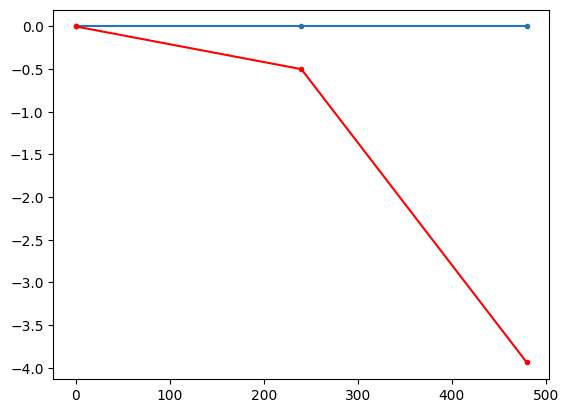

In [140]:
import matplotlib.pyplot as plt
N = len(nodes)
y = np.zeros([N])
plt.plot(results['coordinate'],y,'.-')

plt.plot(results['coordinate'],results['displacement'],'r.-')

plt.show()